In [333]:
# dmu9 dataset downloaded from https://gdb.unibe.ch/downloads/
smiles = open('1to6.dmu.smi', 'r').read().splitlines()   # 1 - 6 heavy atoms only
print(len(smiles))
assert len(smiles) == len(set(smiles)), "Remove duplicates!" # check for duplicates
smiles[:10]

35466


['C', 'N', 'O', 'C#C', 'C#N', 'N#N', 'C=C', 'C=N', 'C=O', 'N=N']

In [334]:
tokens = sorted(set(''.join(smiles)))
stoi = {ch:i+1 for i,ch in enumerate(tokens)}    # character to index
stoi['.'] = 0
itos = {i:ch for ch,i in stoi.items()}  # index to character

In [335]:
stoi

{'#': 1,
 '(': 2,
 ')': 3,
 '1': 4,
 '2': 5,
 '3': 6,
 '4': 7,
 '5': 8,
 '=': 9,
 'C': 10,
 'N': 11,
 'O': 12,
 '.': 0}

In [336]:
import numpy as np
N = np.zeros((len(stoi), len(stoi)), dtype=np.int32)
for s in smiles:
    chs = ['.'] + list(s) + ['.']
    for ch1,ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1

In [337]:
N.shape

(13, 13)

(-0.5, 12.5, 12.5, -0.5)

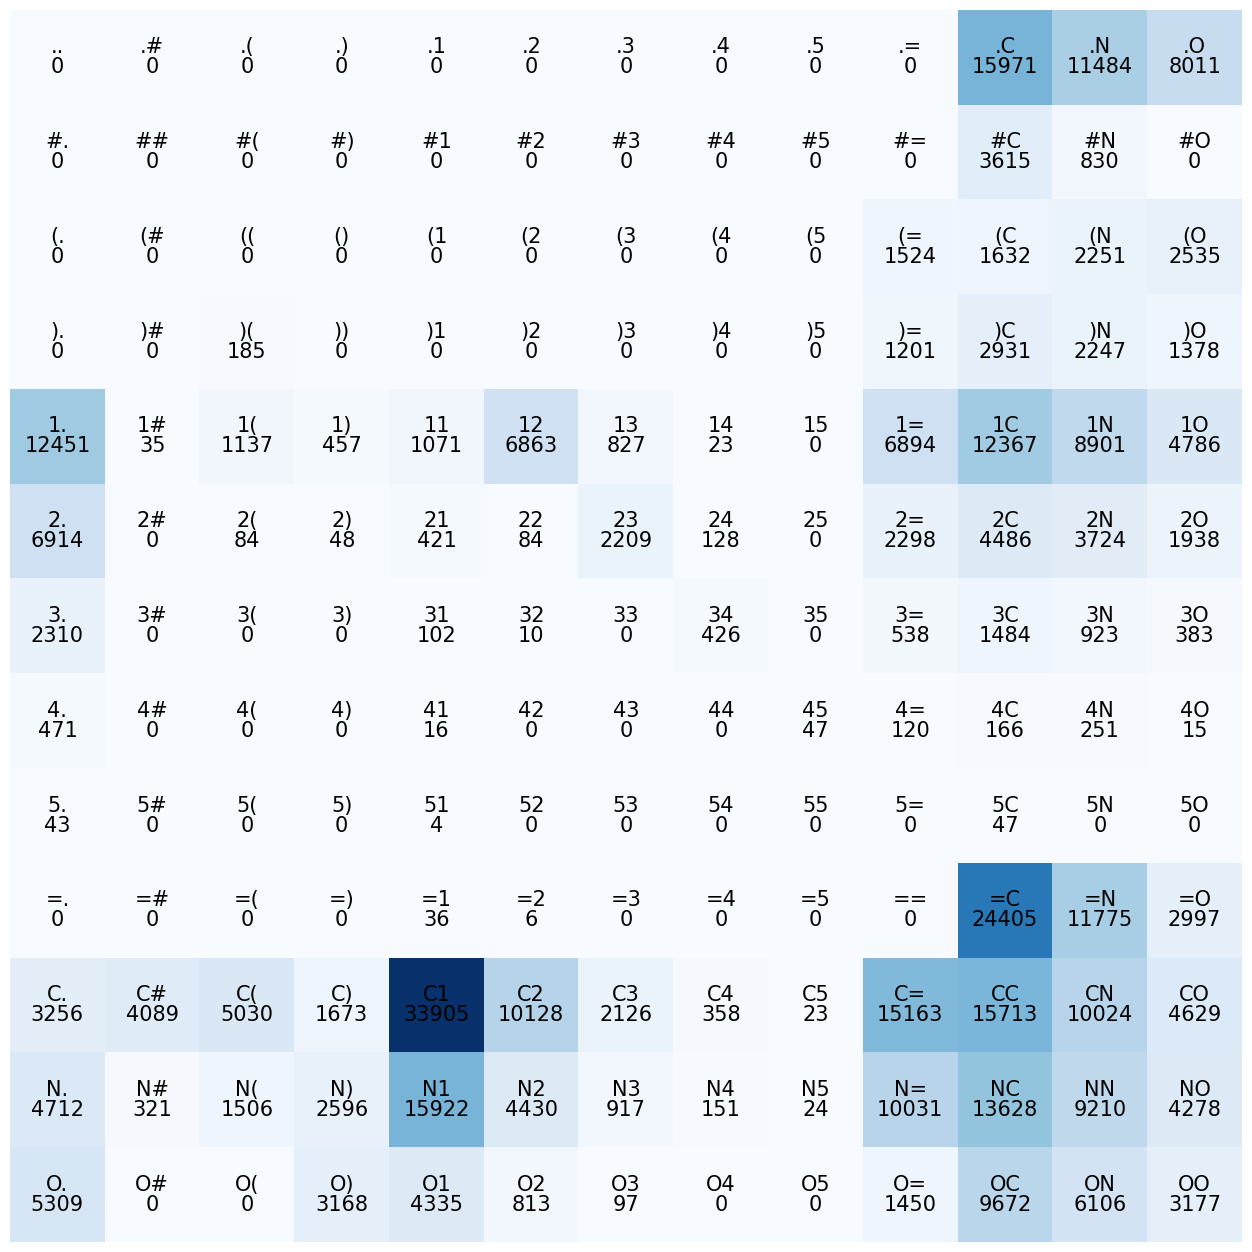

In [338]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 16))
ax.imshow(N, cmap='Blues')
for i in range(len(stoi)):
    for j in range(len(stoi)):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha='center', va='bottom', color='k', fontsize=15)
        plt.text(j, i, N[i, j].item(), ha='center', va='top', color='k', fontsize=15)
plt.axis('off')

In [339]:
import torch
# Build dataset
def build_dataset(smiles): 
    X, Y = [], []
    for s in smiles:
        chs = ['.'] + list(s) + ['.']   
        for ch1, ch2 in zip(chs, chs[1:]):
            ix1 = stoi[ch1]
            ix2 = stoi[ch2]
            X.append(ix1)
            Y.append(ix2)
            #print(itos[ix1], '--->', itos[ix2])
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(smiles)
n1 = int(len(smiles) * 0.8)
n2 = int(len(smiles) * 0.9)

#Xtr, Ytr = build_dataset(smiles)
Xtr, Ytr = build_dataset(smiles[:n1])
Xdev,Ydev = build_dataset(smiles[n1:n2])
Xte, Yte = build_dataset(smiles[n2:])

torch.Size([310619]) torch.Size([310619])
torch.Size([38929]) torch.Size([38929])
torch.Size([38938]) torch.Size([38938])


In [340]:
Ytr.shape

torch.Size([310619])

In [341]:
# Set up model
g = torch.Generator().manual_seed(2147483647)
W = torch.rand((len(stoi), len(stoi)), generator=g)
#b = torch.rand(len(stoi), generator=g)
parameters = [W]
for p in parameters:
    p.requires_grad = True

In [342]:
import torch.nn.functional as F
for _ in range(10000):
    
    # crate batch
    idx = torch.randint(len(Xtr), (100,)) # 100 random indices
    xenc = F.one_hot(Xtr[idx], num_classes=len(stoi)).float()

    logits = xenc @ W 
    
    #counts = logits.exp() 
    #prob = counts / counts.sum(1, keepdims=True) 
    #loss = -prob[torch.arange(len(Xtr)), Ytr].log().mean() 
    loss = F.cross_entropy(logits, Ytr[idx])
    
    # backward
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1
    for p in parameters:
        p.data -= lr * p.grad.data
print(loss.item())

1.7959039211273193


In [343]:
# Training error
xenc = F.one_hot(Xtr, num_classes=len(stoi)).float()
logits = xenc @ W 
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

1.7742857933044434


In [344]:
# Dev error
xenc = F.one_hot(Xdev, num_classes=len(stoi)).float()
logits = xenc @ W 
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

1.78056001663208


In [345]:
# Make predictions
#g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    ix = 0
    while True:
        xenc = F.one_hot(torch.tensor([ix]), num_classes=len(stoi)).float()
        logits = xenc @ W 
        probs = F.softmax(logits, 1)
        ix = torch.multinomial(probs, 1, replacement=True).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

O)#C4C1)=C=5(O1.
O.
CC1(=C1.
NN2ONN2.
N=C1C(O.
N1C=C1=NN1NN=CN1.
C12N.
C23.
C1NC#NN1=C=C1=C12.
OC(NC1.
C12NNC12N1C1NN1N=C1O2C=N.
O)CCO1C=C(NC1CCC22=CC1.
C1C12CNN=C11=N=C1N)C1CC=CC1CC12.
C#CC1OC1(OC.
O)O.
C2O.
CCCC#C1C12.
CC(O.
.
ON(O.


(-0.5, 12.5, 12.5, -0.5)

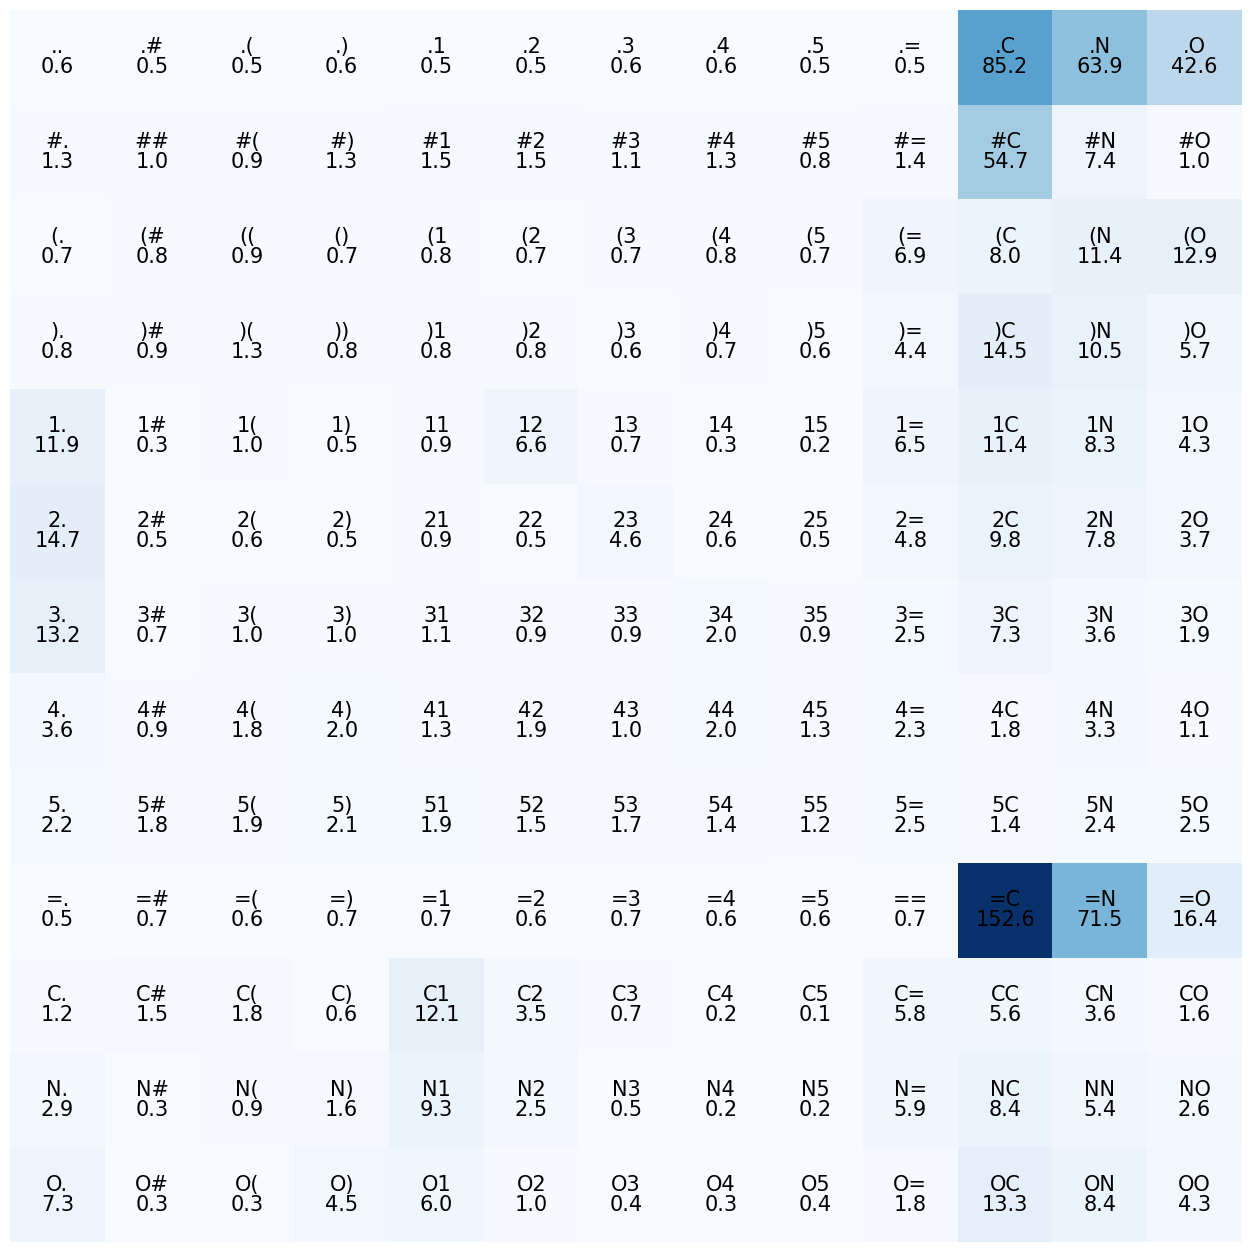

In [346]:
# To show that W is equivalent to N, well almost
ig, ax = plt.subplots(figsize=(16, 16))
count = (W).exp()
ax.imshow(count.data, cmap='Blues')
for i in range(len(stoi)):
    for j in range(len(stoi)):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha='center', va='bottom', color='k', fontsize=15)
        plt.text(j, i, round(count[i, j].item(),1), ha='center', va='top', color='k', fontsize=15)
plt.axis('off')